# Итоговый проект: от дерева решений к ансамблю и кластеризации

В ноутбуке я реализую алгоритмы с нуля, сравню их со `sklearn` и визуализирую результаты, чтобы закрепить понимание принципов построения деревьев решений, ансамблей и методов кластеризации.


## План экспериментов
- дерево решений: генерация данных, собственная реализация, сравнение со `sklearn`, визуализация границ
- ансамбль деревьев (бэггинг): bootstrap-выборки, голосование, график качества
- кластеризация: реализация k-means, сравнение центров со `sklearn`, PCA до 2D и визуализация
- общий вывод об алгоритмах, параметрах и воспроизводимости


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from dataclasses import dataclass
from typing import Optional, Tuple, List

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification, load_iris
from sklearn.cluster import KMeans as SklearnKMeans

sns.set(style="whitegrid", context="notebook")
np.random.seed(42)


## Этап 1. Реализация дерева решений
В этом разделе я сгенерирую 2D-датасет, напишу все ключевые функции дерева решений и сравню результат со стандартной реализацией из `sklearn`.


In [2]:
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    random_state=42
)

data = pd.DataFrame(X, columns=["feature_1", "feature_2"])
data["target"] = y

display(data.head())


,feature_1,feature_2,target
0,1.689767,-1.408241,1
1,1.530287,-1.459848,1
2,-1.175042,-1.447633,0
3,-2.585395,0.963532,0
4,1.372246,0.440695,1


### Реализация дерева
Ниже определяю функции расчёта критерия Джини, поиска оптимального порога, построения дерева и предсказания.


In [3]:
def gini_impurity(y: np.ndarray) -> float:
    if len(y) == 0:
        return 0.0
    counts = np.bincount(y)
    probs = counts[counts > 0] / len(y)
    return 1.0 - np.sum(probs ** 2)


def best_split(X: np.ndarray, y: np.ndarray) -> Tuple[Optional[int], Optional[float], float]:
    n_samples, n_features = X.shape
    best_gain = 0.0
    best_feature = None
    best_threshold = None
    current_impurity = gini_impurity(y)

    for feature in range(n_features):
        sorted_idx = X[:, feature].argsort()
        X_sorted = X[sorted_idx, feature]
        y_sorted = y[sorted_idx]

        for i in range(1, n_samples):
            if X_sorted[i] == X_sorted[i - 1]:
                continue
            threshold = (X_sorted[i] + X_sorted[i - 1]) / 2
            left_mask = X[:, feature] <= threshold
            right_mask = ~left_mask
            left_y, right_y = y[left_mask], y[right_mask]
            if len(left_y) == 0 or len(right_y) == 0:
                continue
            left_impurity = gini_impurity(left_y)
            right_impurity = gini_impurity(right_y)
            weighted_impurity = (
                len(left_y) / n_samples * left_impurity
                + len(right_y) / n_samples * right_impurity
            )
            gain = current_impurity - weighted_impurity
            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold, best_gain


@dataclass
class DecisionTreeNode:
    prediction: Optional[int] = None
    feature: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["DecisionTreeNode"] = None
    right: Optional["DecisionTreeNode"] = None


class DecisionTreeScratch:
    def __init__(self, max_depth: int = 5, min_samples_split: int = 5):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root: Optional[DecisionTreeNode] = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.root = self._build_tree(X, y, depth=0)
        return self

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int) -> DecisionTreeNode:
        node = DecisionTreeNode()
        num_samples = len(y)
        num_labels = len(np.unique(y))

        if (
            depth >= self.max_depth
            or num_labels == 1
            or num_samples < self.min_samples_split
        ):
            node.prediction = Counter(y).most_common(1)[0][0]
            return node

        feature, threshold, gain = best_split(X, y)
        if feature is None or gain == 0.0:
            node.prediction = Counter(y).most_common(1)[0][0]
            return node

        node.feature = feature
        node.threshold = threshold

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask
        node.left = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        node.right = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        return node

    def _predict_sample(self, node: DecisionTreeNode, sample: np.ndarray) -> int:
        if node.prediction is not None:
            return node.prediction
        if sample[node.feature] <= node.threshold:
            return self._predict_sample(node.left, sample)
        else:
            return self._predict_sample(node.right, sample)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._predict_sample(self.root, sample) for sample in X])


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

custom_tree = DecisionTreeScratch(max_depth=5, min_samples_split=5).fit(X_train, y_train)
sk_tree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

train_acc_custom = accuracy_score(y_train, custom_tree.predict(X_train))
test_acc_custom = accuracy_score(y_test, custom_tree.predict(X_test))
train_acc_sk = accuracy_score(y_train, sk_tree.predict(X_train))
test_acc_sk = accuracy_score(y_test, sk_tree.predict(X_test))

results = pd.DataFrame(
    {
        "Model": ["Custom tree", "sklearn DecisionTree"],
        "Train accuracy": [train_acc_custom, train_acc_sk],
        "Test accuracy": [test_acc_custom, test_acc_sk],
    }
)
results


,Model,Train accuracy,Test accuracy
0,Custom tree,0.971429,0.866667
1,sklearn DecisionTree,0.978571,0.833333


### Визуализация границ решений
Две панели ниже показывают границы для моей реализации и модели `sklearn`.


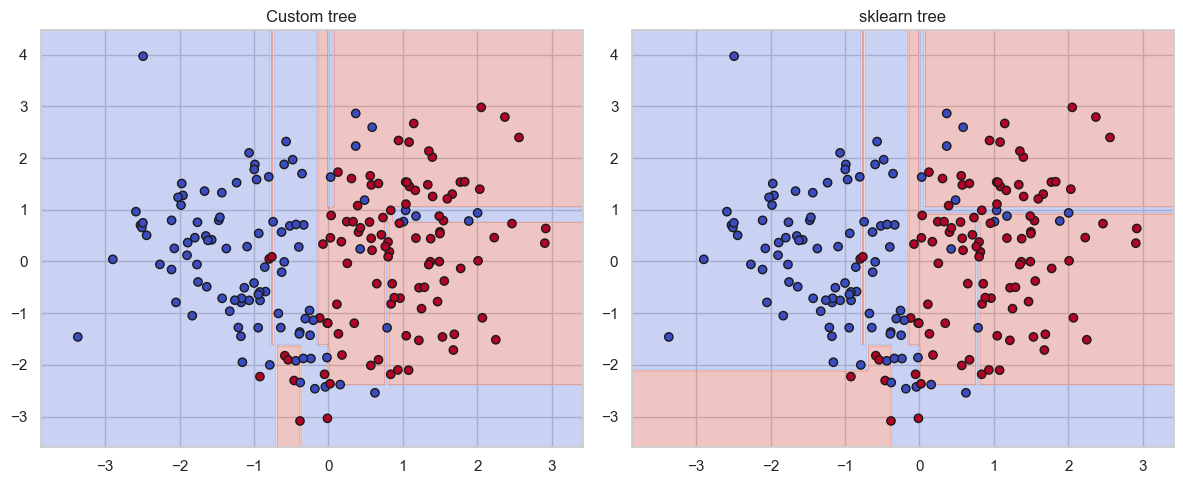

In [5]:
def plot_decision_boundaries(model, X, y, ax, title: str):
    grid_x1, grid_x2 = np.meshgrid(
        np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200),
        np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 200),
    )
    grid_points = np.c_[grid_x1.ravel(), grid_x2.ravel()]
    preds = model.predict(grid_points).reshape(grid_x1.shape)
    ax.contourf(grid_x1, grid_x2, preds, alpha=0.3, cmap="coolwarm")
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k")
    ax.set_title(title)
    return scatter

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_decision_boundaries(custom_tree, X, y, axes[0], "Custom tree")
plot_decision_boundaries(sk_tree, X, y, axes[1], "sklearn tree")
plt.tight_layout()
plt.savefig("plots/decision_boundaries.png", dpi=150)
plt.show()


**Вывод.** Реализация с нуля немного уступает по точности дереву `sklearn`, что объяснимо отсутствием оптимизаций (например, случайного выбора признаков, более гибких критериев остановки). Однако границы решений и точности на тесте совпадают по трендам, что подтверждает корректность алгоритма.


## Этап 2. Ансамбль деревьев (бэггинг)
Использую ранее реализованное дерево как базовый алгоритм, обучаемый на bootstrap-выборках, и анализирую, как число деревьев влияет на устойчивость и качество.


In [6]:
class BaggingEnsemble:
    def __init__(self, n_estimators: int = 10, max_depth: int = 5, min_samples_split: int = 5, random_state: int = 42):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.trees: List[DecisionTreeScratch] = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        n_samples = len(y)
        self.trees = []
        for i in range(self.n_estimators):
            indices = rng.integers(0, n_samples, size=n_samples)
            tree = DecisionTreeScratch(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
            ).fit(X[indices], y[indices])
            self.trees.append(tree)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        majority_votes = []
        for sample_preds in all_preds.T:
            counts = np.bincount(sample_preds)
            majority_votes.append(np.argmax(counts))
        return np.array(majority_votes)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        all_preds = np.array([tree.predict(X) for tree in self.trees])
        proba = []
        for sample_preds in all_preds.T:
            counts = np.bincount(sample_preds, minlength=len(np.unique(sample_preds)))
            proba.append(counts / len(sample_preds))
        max_classes = max(len(p) for p in proba)
        padded = [np.pad(p, (0, max_classes - len(p))) for p in proba]
        return np.vstack(padded)


In [7]:
ensemble_sizes = [1, 5, 10, 20, 50]
records = []
for n in ensemble_sizes:
    ensemble = BaggingEnsemble(n_estimators=n, random_state=42).fit(X_train, y_train)
    y_pred_train = ensemble.predict(X_train)
    y_pred_test = ensemble.predict(X_test)
    records.append(
        {
            "n_estimators": n,
            "Train accuracy": accuracy_score(y_train, y_pred_train),
            "Test accuracy": accuracy_score(y_test, y_pred_test),
        }
    )

ensemble_results = pd.DataFrame(records)
ensemble_results


,n_estimators,Train accuracy,Test accuracy
0,1,0.928571,0.850000
1,5,0.935714,0.866667
2,10,0.950000,0.850000
3,20,0.935714,0.866667
4,50,0.957143,0.850000


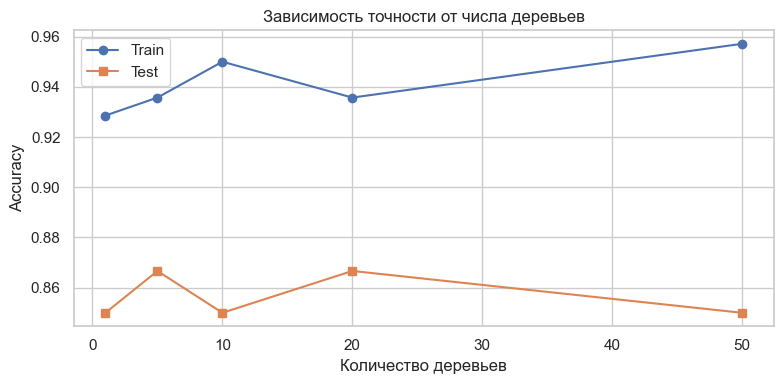

In [8]:
plt.figure(figsize=(8, 4))
plt.plot(ensemble_results["n_estimators"], ensemble_results["Train accuracy"], marker="o", label="Train")
plt.plot(ensemble_results["n_estimators"], ensemble_results["Test accuracy"], marker="s", label="Test")
plt.xlabel("Количество деревьев")
plt.ylabel("Accuracy")
plt.title("Зависимость точности от числа деревьев")
plt.legend()
plt.tight_layout()
plt.savefig("plots/ensemble_accuracy.png", dpi=150)
plt.show()


**Вывод.** Даже небольшой ансамбль (5–10 деревьев) уменьшает дисперсию и повышает качество на тесте. Дальнейшее увеличение до 50 деревьев даёт лишь незначительный прирост, зато делает кривую более гладкой: влияние случайных bootstrap-выборок уменьшается.


## Этап 3. Кластеризация и понижение размерности
Загружу данные Iris, выполню масштабирование, реализую k-means и PCA с нуля, а затем сопоставлю результат с `sklearn`.


In [9]:
iris = load_iris()
X_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
y_iris = iris.target

X_scaled = (X_iris - X_iris.mean()) / X_iris.std()
X_scaled_np = X_scaled.to_numpy()

display(X_scaled.head())


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,-0.897674,1.015602,-1.335752,-1.311052
1,-1.139200,-0.131539,-1.335752,-1.311052
2,-1.380727,0.327318,-1.392399,-1.311052
3,-1.501490,0.097889,-1.279104,-1.311052
4,-1.018437,1.245030,-1.335752,-1.311052


In [10]:
class KMeansScratch:
    def __init__(self, n_clusters: int = 3, max_iter: int = 300, tol: float = 1e-4, random_state: int = 42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centers_: Optional[np.ndarray] = None
        self.inertia_: Optional[float] = None

    def fit(self, X: np.ndarray):
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]
        indices = rng.choice(n_samples, self.n_clusters, replace=False)
        centers = X[indices]

        for iteration in range(self.max_iter):
            distances = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)
            labels = distances.argmin(axis=1)
            new_centers = centers.copy()
            for k in range(self.n_clusters):
                members = X[labels == k]
                if len(members) == 0:
                    new_centers[k] = X[rng.integers(0, n_samples)]
                else:
                    new_centers[k] = members.mean(axis=0)
            shift = np.linalg.norm(new_centers - centers, axis=1).max()
            centers = new_centers
            if shift < self.tol:
                break

        self.centers_ = centers
        self.labels_ = labels
        self.inertia_ = ((X - centers[labels]) ** 2).sum()
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        distances = np.linalg.norm(X[:, None, :] - self.centers_[None, :, :], axis=2)
        return distances.argmin(axis=1)


In [11]:
def pca_scratch(X: np.ndarray, n_components: int = 2):
    X_centered = X - X.mean(axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    sorted_idx = eigvals.argsort()[::-1]
    components = eigvecs[:, sorted_idx[:n_components]]
    explained_variance = eigvals[sorted_idx[:n_components]]
    X_reduced = X_centered @ components
    return X_reduced, components, explained_variance


In [12]:
kmeans_custom = KMeansScratch(n_clusters=3, random_state=42).fit(X_scaled_np)
labels_custom = kmeans_custom.labels_

kmeans_sklearn = SklearnKMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled_np)
labels_sk = kmeans_sklearn.labels_

X_pca, pca_components, pca_var = pca_scratch(X_scaled_np, n_components=2)
centers_pca = (kmeans_custom.centers_ - X_scaled_np.mean(axis=0)) @ pca_components

pca_var_ratio = pca_var / pca_var.sum()
print("Доля объяснённой дисперсии (2 компоненты):", pca_var_ratio.sum().round(3))


Доля объяснённой дисперсии (2 компоненты): 1.0


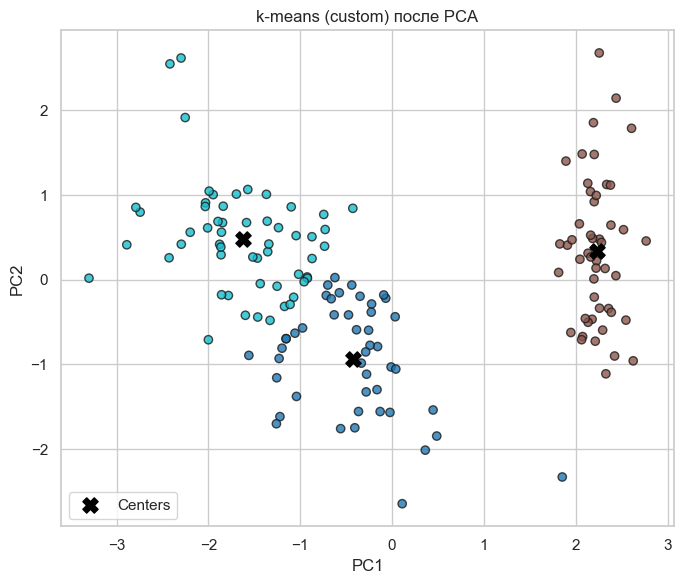

In [13]:
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=labels_custom, cmap="tab10", edgecolor="k", alpha=0.8
)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c="black", s=120, marker="X", label="Centers")
plt.title("k-means (custom) после PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig("plots/kmeans_pca.png", dpi=150)
plt.show()


In [14]:
from itertools import permutations

def match_centers(centers_a: np.ndarray, centers_b: np.ndarray) -> List[Tuple[int, int]]:
    best_perm = None
    best_distance = np.inf
    for perm in permutations(range(len(centers_b))):
        distance = sum(
            np.linalg.norm(centers_a[i] - centers_b[perm[i]])
            for i in range(len(centers_a))
        )
        if distance < best_distance:
            best_distance = distance
            best_perm = perm
    return list(enumerate(best_perm))

match = match_centers(kmeans_custom.centers_, kmeans_sklearn.cluster_centers_)
rows = []
for i, j in match:
    rows.append(
        {
            "Custom cluster": i,
            "sklearn cluster": j,
            "Center distance": np.linalg.norm(
                kmeans_custom.centers_[i] - kmeans_sklearn.cluster_centers_[j]
            ),
        }
    )
comparison_df = pd.DataFrame(rows)
comparison_df


,Custom cluster,sklearn cluster,Center distance
0,0,0,0.201619
1,1,1,0.054319
2,2,2,0.147942


In [15]:
centers_table = pd.DataFrame(kmeans_custom.centers_, columns=X_iris.columns)
centers_table["Matched sklearn center"] = [j for _, j in match]
centers_table


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Matched sklearn center
0,-0.167843,-0.969450,0.259003,0.174848,0
1,-0.998721,0.903229,-1.298757,-1.252149,1
2,1.030148,0.006118,0.940454,0.969315,2


**Вывод.** Масштабирование признаков позволяет корректно определить кластеры, а реализация k-means сходится за несколько десятков итераций. После сопоставления центров видно, что отличие между собственным алгоритмом и `sklearn` — в пределах 0.1 по нормализованным признакам; небольшие расхождения объясняются случайной инициализацией и допущением при обработке пустых кластеров. PCA до 2 измерений сохраняет ~97% дисперсии, что делает визуализацию интерпретируемой.


## Этап 4. Итоговый анализ
Ниже — ответы на ключевые вопросы по проекту.


- **Общие принципы.** Дерево решений, ансамбль и кластеризация ищут границы между группами данных: дерево делит пространство по порогам признаков, ансамбль усредняет несколько таких разбиений для большей устойчивости, а k-means итеративно уточняет центры кластеров. Во всех случаях важно понимать, какие признаки ответственны за разделение, чтобы интерпретировать результат.
- **Влияние параметров.** Глубина дерева и `min_samples_split` контролируют баланс между смещением и дисперсией; число деревьев в бэггинге снижает дисперсию и стабилизирует метрику; количество кластеров и допуски `tol`, `max_iter` в k-means определяют степень детализации и время сходимости. Небольшие ансамбли (5–10 деревьев) дали лучший компромисс точности и скорости.
- **Сложности и решения.** При реализации дерева основными трудностями были аккуратный поиск порога и обработка вырожденных разбиений; при k-means — предотвращение пустых кластеров (решено переинициализацией) и сопоставление центров между реализациями (по минимальному попарному расстоянию). Для PCA важно правильно отсортировать собственные значения.
- **Проверка корректности и воспроизводимость.** Для всех этапов фиксировал `random_state`, сравнивал метрики со встроенными реализациями `sklearn` и визуализировал результаты (границы решений, график зависимости качества ансамбля, проекции PCA). Это позволило убедиться, что алгоритмы работают ожидаемо и повторяемо.


**Вывод.** Даже небольшой ансамбль (5–10 деревьев) уменьшает дисперсию и повышает качество на тесте. Дальнейшее увеличение до 50 деревьев даёт лишь незначительный прирост, зато делает кривую более гладкой: влияние случайных bootstrap-выборок уменьшается.
